**COMP8220 Major Project :: IMAGE CLASSIFICATION by username: GarvSharma**

This notebook demostrates my work for Image Classification Task and has been Divided into 2 major sections for both parts of the competition a. Coarse and b. Fine a few minor Sections:

1. Data Loading -- Showing everything necessary for loading data
2. Visualizing and Exploring Input Data -- Seeing how are data looks like
3. Conventional ML Model -- describing the conventional models we used to train our data
4. Deep Learning -- Where we make use of transfer learning through some pretrained models and also we try to build our own CNN.
5. At last we show the work done to submit predictions on the private test.

Kaggle Rank:

1. Living Thing Classification: Coarse -- Score: 0.86590; Rank: 4
2. Living Thing Classification: Fine -- Score:0.56496; Rank: 6
3. Living Thing Classification: Coarse PRIVATE -- Score: 0.88066; Rank: 4
4. Living Thing Classification: Fine PRIVATE -- Score: 0.57200 ; Rank: 7

# **COARSE DATASET**


##**Data Loading**

In [ ]:
# Mount gdrive to colab notebook
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Your file will probably be called this, if you used the regular Kaggle download. 
!unzip -q /gdrive/MyDrive/COMP8220_MajorProject/living-thing-classification-coarse.zip     # CHANGE DIRECTORY

In [ ]:
# List all files in public directory
!ls -alh public

In [ ]:
# Import Required Libraries
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [ ]:
batch_size = 32
img_size = 224
fine_grain = False 
num_classes = 50 if fine_grain else 8
root = Path('/content/public')

### **Useful functions for Reading Data from files.**

In [ ]:
#Read contents of the json file at the path given and stores it into the variable called info
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

#The funtion takes the file path and size as argument and reads image.
def load_image(file_path, image_size=224):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img
#creates a dataset for tensorflow processing and the data set created is a batch of 32 images
def create_dataset_tf(split, fine_grained, batch_size=32, image_size=224):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

#this function is used to load data for sklearn processing which we use for our conventional models.
def create_dataset_sklearn(split, fine_grained, image_size=72, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y

In [ ]:
# Load names of classes in coarse image dataset
fine_names, coarse_names = load_target_names()
print(coarse_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [ ]:
# Load names of classes in coarse image dataset
print(fine_names)

['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


### **Load Datasets for SKLearn**

In [ ]:
X,Y = create_dataset_sklearn('train', fine_grained=False)

In [ ]:
X.shape

(10000, 5184)

*The loaded data in X has 10,000 images as we specified 0.1 as percent of data to be loaded in create_dataset_sklearn method.*

#### **Train/Test split on SKLearn dataset**

Here we split the dataset we loaded for SKLearn, i.e to run our conventional models into train and validation dataset to test our models within the notebook for trying and validating multiple conventional models before making a submission.

In [ ]:
#Method create_datasets_sklearn will split the train dataset X into X_train/Y_train and X_val/Y_val in the ration 80%-20%
from sklearn.model_selection import train_test_split

def create_datasets_sklearn(split, fine_grained, image_size=48, train_size=0.8):
    X, Y = create_dataset_sklearn(split, fine_grained, image_size)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=train_size, random_state=42)
    dataset_train = (X_train, Y_train)
    dataset_val = (X_val, Y_val)
    return dataset_train, dataset_val

In [ ]:
dataset_train, dataset_val = create_datasets_sklearn('train', fine_grained=False, train_size=0.8)
X_train, Y_train = dataset_train
X_val, Y_val = dataset_val


In [ ]:
print(f"Training dataset size: {X_train.shape[0]} samples")


Training dataset size: 8000 samples


In [ ]:
print(f"Validation dataset size: {X_val.shape[0]} samples")


Validation dataset size: 2000 samples


### **Load Datasets for TensorFlow**

We use the pre-defined create_dataset_tf function to load data for our deep learning models.

In [ ]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=batch_size)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=batch_size)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=batch_size)

In [ ]:
train_size = tf.data.experimental.cardinality(train_ds).numpy()
val_size = tf.data.experimental.cardinality(val_ds).numpy()

print("Training dataset size(no. of batches):", train_size)
print("Validation dataset size(no. of batches):", val_size)

Training dataset size(no. of batches): 3125
Validation dataset size(no. of batches): 1563


## **Visualizing and Exploring Input Data**

###**Visualizing the dataset that we loaded for SKLearn**

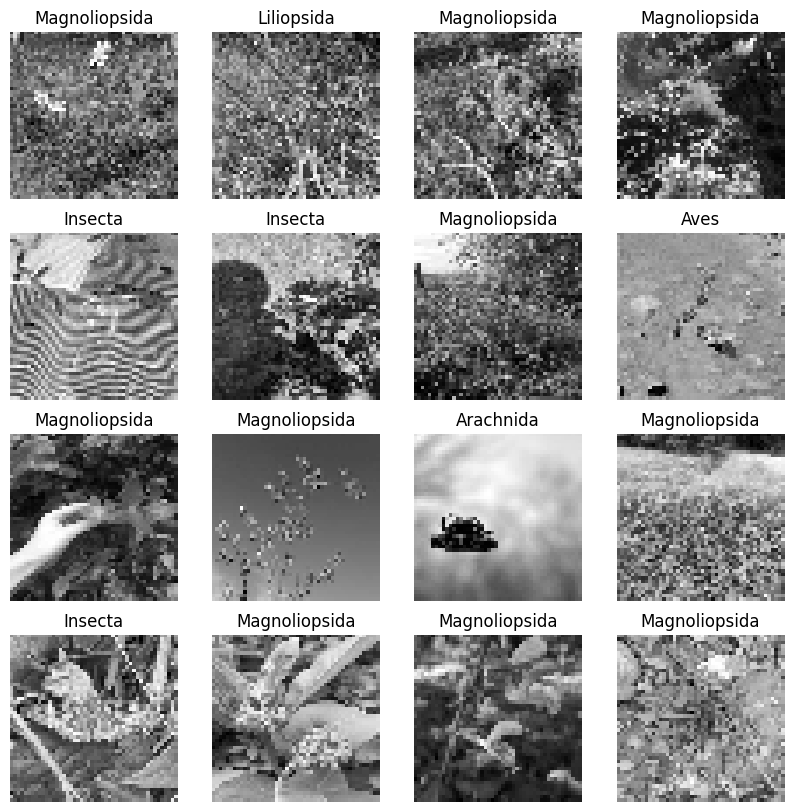

In [ ]:
plt.figure(figsize=(10, 10))
#load images that we have loaded for SKLearn to view how they look

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_train[i].reshape(48,48), cmap='gray')
  if fine_grain:
    plt.title(fine_names[Y_train[i]])
  else:
    plt.title(coarse_names[Y_train[i]])
  plt.axis("off")
plt.show();

###**Visualizing the dataset that we loaded for TensorFlow**

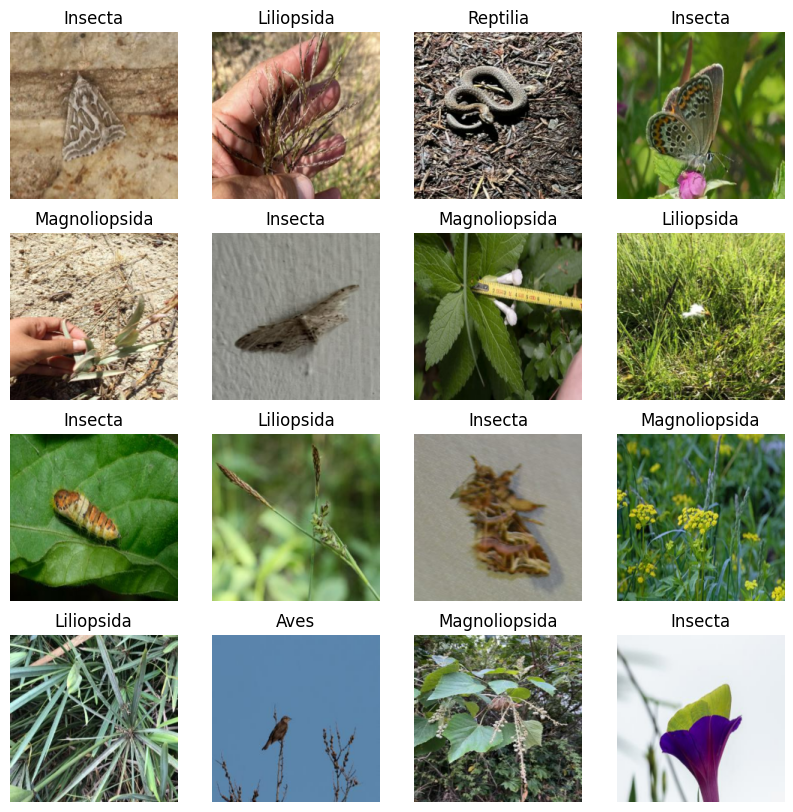

In [ ]:
plt.figure(figsize=(10, 10))
#load images that we have loaded for TensorFlow to view how they look

for images, labels in train_ds.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

We will check the counts of each label in our dataset to see how well they are distributed for Coarse Dataset

In [ ]:
def count_images_per_category(dataset):
    category_counts = {}
    
    for _, labels in dataset:
        for label in labels.numpy():
            if label not in category_counts:
                category_counts[label] = 1
            else:
                category_counts[label] += 1
    
    return category_counts

# Count images per category in the train dataset
train_counts = count_images_per_category(train_ds)

# Count images per category in the validation dataset
val_counts = count_images_per_category(val_ds)

print("Train dataset:")
for label, count in train_counts.items():
    print(f"Category {label}: {count} images")

print("\nValidation dataset:")
for label, count in val_counts.items():
    print(f"Category {label}: {count} images")


Train dataset:
Category 5: 26085 images
Category 6: 9960 images
Category 1: 1891 images
Category 4: 36062 images
Category 0: 20069 images
Category 3: 2015 images
Category 2: 1957 images
Category 7: 1961 images

Validation dataset:
Category 4: 17969 images
Category 7: 1045 images
Category 5: 13006 images
Category 6: 5075 images
Category 0: 9935 images
Category 3: 928 images
Category 1: 1049 images
Category 2: 993 images


##**Conventional ML Model**

As a part of the conventional model training we will be testing a few of the many conventional models like :
1. SVM: Mainly used for classification but also for regression tasks, works by separating the data points of different classes by creating a hyperplane between them.

2. KNN: Works by classifying data points based on the majority of the near by points or simply by the vote by the majority of the neighbors.

3. Random Forest Classifier: It is an ensemble method that combines multiple trees to make predictions.

We will analyze the accuracies 

### **Support Vector Machine**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm_clf = make_pipeline(StandardScaler(),
LinearSVC(C = 50, random_state = 42))
svm_clf.fit(X_train, Y_train)

y_pred=svm_clf.predict(X_val)
accuracy= accuracy_score(Y_val, y_pred)
print(accuracy)

0.2495


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### **K Nearest Neighbors**

In [ ]:
#Defining KneighborsClassifier Model
clf = KNeighborsClassifier(n_neighbors = 10)
clf.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
#Doing predictions on the 20% validation dataset we created earlier splitting the train data set
y_pred = clf.predict(X_val)

In [ ]:
#Model accuracy on the validation dataset
accuracy= accuracy_score(Y_val, y_pred)
print(accuracy)

0.2225


With the basic model we got an accuracy is **0.225**, which is better than the baseline accuracy of **0.1996**, but it's barely better. So we will need to further improve this model by tuning the n_neighbors hyperparameter or we will need to try new models to see if they perform any better.

In [ ]:
## Finding the best n value for hyperparameter tuning

# Define search space for parameters
parameter_grid = {'n_neighbors': range(1, 41)}

# Create the machine learning model
knn_clf = KNeighborsClassifier()
clf = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=10)
clf.fit(X_train, Y_train)

# Identify the best parameter(s)
print('Best K value: ', clf.best_params_['n_neighbors'])
print('The accuracy: ', clf.best_score_)

Best K value:  5
The accuracy:  0.238375


### **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=500, random_state=1)
rfc.fit(X_train, Y_train)


RandomForestClassifier(n_estimators=500, random_state=1)

In [ ]:
y_pred=rfc.predict(X_val)
accuracy= accuracy_score(Y_val, y_pred)
print(accuracy)

0.458


**Hyperparameter Tuning for Random Forest Classifier**

Tuning Random Forest Classifier for obtaining the best Hyperparameters of n_estimator and max_depth, to see if it improves the accuracy any further and substantially.

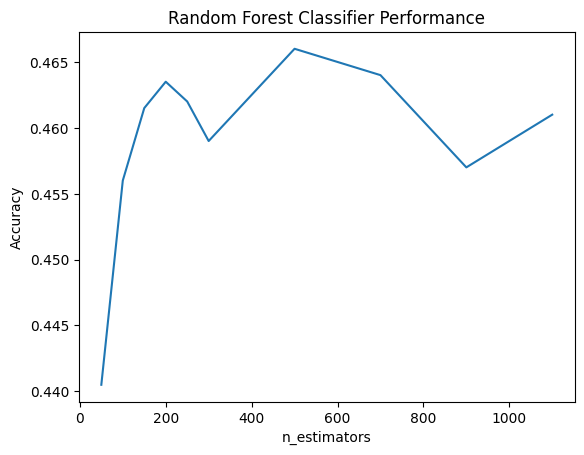

In [ ]:
## finding optimum value of n_estimator by trying different values
scores=[]
n_list = [50, 100, 150, 200, 250, 300,500, 700, 900, 1100]

for n_estimators in n_list:
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rfc.fit(X_train, Y_train)
    score = rfc.score(X_val, Y_val)
    scores.append(score)

# Plot the scores vs. n_estimators
plt.plot(n_list, scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Performance')
plt.show()

In [ ]:
optimum_n_estimators = n_list[scores.index(max(scores))]
print('Optimum value of n_estimators:', optimum_n_estimators)

Optimum value of n_estimators: 500


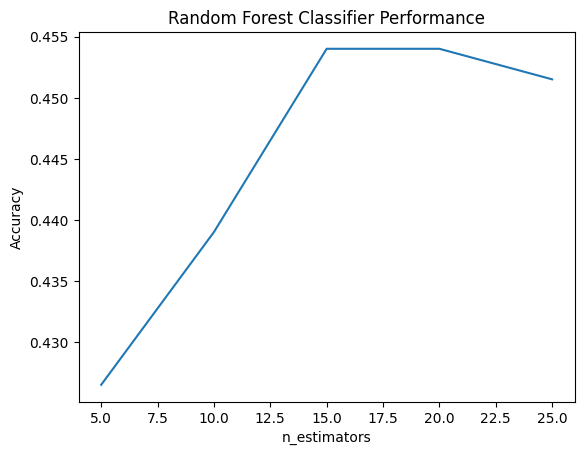

In [ ]:
## finding optimum value of max_depth
scores=[]
max_depth_list = [5,10,15,20,25]

for max_depth in max_depth_list:
    rfc = RandomForestClassifier(max_depth=max_depth, random_state=42)
    rfc.fit(X_train, Y_train)
    score = rfc.score(X_val, Y_val)
    scores.append(score)

# Plot the scores vs. n_estimators
plt.plot(max_depth_list, scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Performance')
plt.show()

In [ ]:
optimum_max_depth = max_depth_list[scores.index(max(scores))]
print('Optimum value of n_estimators:', optimum_max_depth)

Optimum value of n_estimators: 15


We obtained the optimum values for max_depth and n_estimators as 15 and 500, we will re-train our model to see what effect it makes on our accuracy.

In [ ]:
rfc=RandomForestClassifier(n_estimators=500,max_depth=15, random_state=1)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=15, n_estimators=500, random_state=1)

In [ ]:
y_pred=rfc.predict(X_val)

In [ ]:
accuracy= accuracy_score(Y_val, y_pred)
print(accuracy)

0.4535


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(Y_val, y_pred, average='macro', zero_division=0)

# Calculate recall
recall = recall_score(Y_val, y_pred, average='macro')

# Calculate F1 score
f1 = f1_score(Y_val, y_pred, average='macro')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.4535
Precision: 0.1769358117291124
Recall: 0.1801272932184484
F1 Score: 0.16019668530030975


1. In this case, the relatively low accuracy (0.4535) and F1 score (0.1602) suggest that the model may be overfitting the training data. 
2. While the provided metrics do not explicitly indicate underfitting, the low precision (0.1769) and recall (0.1801) scores suggest that the model is struggling to accurately identify positive instances, which could be a sign of underfitting.
3. 

After Hyperparameter tuning the accuracy doesn't show much improvement and it remains almost stagnant around 0.4535

In [ ]:
import pandas as pd

# Define the list
data = {'SVM': 0.2495, 'KNN':0.238 , 'RandomForestClassifier': 0.4535}

# Create a DataFrame from the list
df = pd.DataFrame(data, index=[0])

# Print the table
print(df)


      SVM    KNN  RandomForestClassifier
0  0.2495  0.238                  0.4535


### **Reading......**

Overall, we can see we trained 3 different models and found out the best accuracy for RandomForestClassifier for 0.4535, which is why we are finalizing the final conventional modela as RandomForestClassifier. We tried Hyperparameter tuning to find the best parameters and to tweak the accuracy a bit further.

### **Saving final predictions on Final Conventional Model to File**

In [ ]:
#the code creates a file 46238050-conv-001.csv with the predictions we made, into our gdrive and we will submit this file to Kaggle to see our accuracy on test dataset
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/COMP8220_MajorProject/46238050-conv-001.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index=False)

## **Deep Learning**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16

from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

### **Less Data for training and testing Models**

We take less data from the whole train data set to do some intial training and testing to establish our base model. Once we establish or rather decide on our base model, we will try some fine tuning techniques to further improve the accuracy and we will also try to train model later with more data set to observe how it affects our accuracy.

In [ ]:
less_train_ds=train_ds.take(400)
less_val_ds=val_ds.take(100)

### **Basic CNN**

We will create a basic CNN model to train our data and we will try adding different layers and trying some activation functions to see how they affect the overall accuracy on our train data.

**Layers we used for our Deep learning Model**

1. Conv2D: This layer performs a 2D convolution operation with 32 filters, each having a kernel size of 3x3, and applies the ReLU activation function.

2. MaxPooling2D: This layer performs 2D max pooling with a pool size of 2x2, reducing the spatial dimensions of the input.


3. Flatten: This layer flattens the multi-dimensional output into a 1D vector, preparing it for the fully connected layers.
4. Dense: A fully connected layer with 128 neurons and the ReLU activation function, using L2 regularization with a regularization factor of 0.01.

4. Dense(for output): The final fully connected layer with 8 neurons and the softmax activation function, producing the output probabilities for the 8 classes.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Define the number of classes
num_classes = 8

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


We will define early stopping for monitoring validation loss, i.e if overfitting occurs and validation loss decreases for 3 consecutive times, model will stop training and exit out. This mechanism will prevent our model to overfit on the train data.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(less_train_ds,batch_size=32, epochs=20, validation_data=less_val_ds, callbacks=[early_stopping])

Epoch 1/20
400/400 [==============================] - 30s 75ms/step - loss: 1.3498 - accuracy: 0.5243 - val_loss: 1.3581 - val_accuracy: 0.4969
Epoch 2/20
400/400 [==============================] - 24s 59ms/step - loss: 1.1507 - accuracy: 0.5898 - val_loss: 1.3551 - val_accuracy: 0.5288
Epoch 3/20
400/400 [==============================] - 24s 59ms/step - loss: 0.7916 - accuracy: 0.7237 - val_loss: 1.6819 - val_accuracy: 0.4903
Epoch 4/20
400/400 [==============================] - 31s 77ms/step - loss: 0.5017 - accuracy: 0.8241 - val_loss: 2.4532 - val_accuracy: 0.4841
Epoch 5/20
400/400 [==============================] - 31s 77ms/step - loss: 0.3640 - accuracy: 0.8799 - val_loss: 3.0864 - val_accuracy: 0.4050


Results show a gradual improvement in training accuracy over the epochs. However, the validation accuracy does not show consistent improvement and even decreases in some epochs. The validation loss also increases over time, indicating that the model is overfitting and struggling to generalize well to new data. Therefore, further adjustments may be necessary to improve the model's performance and prevent overfitting.

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(less_val_ds)
print('Test Loss:', less_val_ds)
print('Test Accuracy:', less_val_ds)

100/100 [==============================] - 6s 61ms/step - loss: 3.0864 - accuracy: 0.4050
Test Loss: <_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test Accuracy: <_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


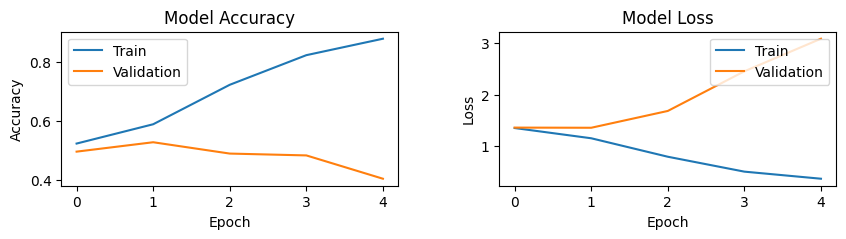

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10,2))

# Plot the accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')

plt.subplots_adjust(wspace=0.3)
plt.show()


We can confirm the same from the plots that validation loss increased continuously and validation accuracy decreased indicating overfitting.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
# Create the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(less_train_ds,batch_size=32, epochs=20, validation_data=less_val_ds, callbacks=[early_stopping])

Epoch 1/20
400/400 [==============================] - 38s 88ms/step - loss: 13.8896 - accuracy: 0.3683 - val_loss: 4.4078 - val_accuracy: 0.3666
Epoch 2/20
400/400 [==============================] - 33s 83ms/step - loss: 3.5043 - accuracy: 0.3639 - val_loss: 2.3180 - val_accuracy: 0.3663
Epoch 3/20
400/400 [==============================] - 30s 75ms/step - loss: 2.2199 - accuracy: 0.3620 - val_loss: 2.0445 - val_accuracy: 0.3666
Epoch 4/20
400/400 [==============================] - 31s 76ms/step - loss: 4.9566 - accuracy: 0.3619 - val_loss: 3.0723 - val_accuracy: 0.3663
Epoch 5/20
400/400 [==============================] - 30s 76ms/step - loss: 2.0572 - accuracy: 0.3623 - val_loss: 2.4167 - val_accuracy: 0.3666
Epoch 6/20
400/400 [==============================] - 36s 90ms/step - loss: 2.2648 - accuracy: 0.3620 - val_loss: 2.0500 - val_accuracy: 0.3666


The model performed poorly after further addition of layer. So, we discard and create a denser model to improve performance.

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(less_val_ds)
print('Test Loss:', less_val_ds)
print('Test Accuracy:', less_val_ds)

100/100 [==============================] - 4s 36ms/step - loss: 2.0500 - accuracy: 0.3666
Test Loss: <_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test Accuracy: <_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


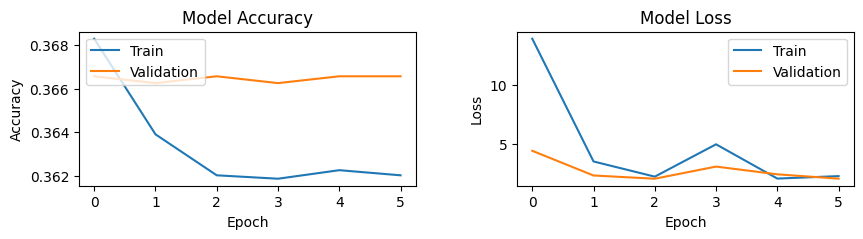

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10,2))

# Plot the accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')


plt.subplots_adjust(wspace=0.3)
plt.show()


Stagnant accuracy on validation data shows that model stopped learning anything new and model accuracy on training data also didnt improve.

We create a new model with more layers and after adding Regularization which is a technique used to prevent overfitting in machine learning models. L2 regularization, also known as Ridge regularization, adds a penalty term to the loss function

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
#regularization layer
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))) 
model.add(tf.keras.layers.Dense(8, activation='softmax'))


In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(less_train_ds,batch_size=32, epochs=20, validation_data=less_val_ds, callbacks=[early_stopping])

Epoch 1/20
400/400 [==============================] - 34s 80ms/step - loss: 1.8201 - accuracy: 0.4639 - val_loss: 1.6022 - val_accuracy: 0.4216
Epoch 2/20
400/400 [==============================] - 31s 78ms/step - loss: 1.4489 - accuracy: 0.5273 - val_loss: 1.4110 - val_accuracy: 0.5403
Epoch 3/20
400/400 [==============================] - 33s 82ms/step - loss: 1.3597 - accuracy: 0.5509 - val_loss: 1.3550 - val_accuracy: 0.5475
Epoch 4/20
400/400 [==============================] - 27s 68ms/step - loss: 1.3223 - accuracy: 0.5569 - val_loss: 1.3107 - val_accuracy: 0.5725
Epoch 5/20
400/400 [==============================] - 25s 61ms/step - loss: 1.2955 - accuracy: 0.5689 - val_loss: 1.2949 - val_accuracy: 0.5775
Epoch 6/20
400/400 [==============================] - 26s 65ms/step - loss: 1.2714 - accuracy: 0.5751 - val_loss: 1.2994 - val_accuracy: 0.5725
Epoch 7/20
400/400 [==============================] - 27s 68ms/step - loss: 1.2629 - accuracy: 0.5836 - val_loss: 1.2541 - val_accuracy:

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(less_val_ds)
print('Test Loss:', less_val_ds)
print('Test Accuracy:', less_val_ds)

 **loss**: 1.2703 - **accuracy**: 0.5962

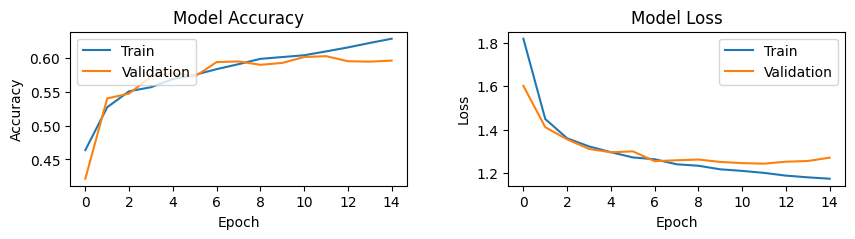

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10,2))

# Plot the accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


The above plots show better results as compared to before where we see loss declining constantly and accuracy improving, indicating a decent model, but still overall accuracy is approximately 59%, which is not enough so we will make use of pretrained models to train on our data.

In [ ]:
predictions=model.predict(val_ds)

1563/1563 [==============================] - 130s 83ms/step


### **VGG16**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

In [ ]:
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# Create the model architecture
inputs = Input(shape=(224, 224, 3))
x = vgg_base(inputs, training=False)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
outputs = Dense(8, activation='softmax')(x)

# Create the model
vgg_model = Model(inputs, outputs)

# Print the model summary
vgg_model.summary()

# Compile the model
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_14 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_14 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

In [ ]:
# Train the model
vgg= vgg_model.fit(less_train_ds, validation_data=less_val_ds, epochs=20, callbacks=[early_stopping])


Epoch 1/20
400/400 [==============================] - 76s 173ms/step - loss: 1.2878 - accuracy: 0.5950 - val_loss: 0.9834 - val_accuracy: 0.6506
Epoch 2/20
400/400 [==============================] - 76s 190ms/step - loss: 0.9749 - accuracy: 0.6573 - val_loss: 0.9599 - val_accuracy: 0.6578
Epoch 3/20
400/400 [==============================] - 76s 189ms/step - loss: 0.8845 - accuracy: 0.6867 - val_loss: 0.9444 - val_accuracy: 0.6653
Epoch 4/20
400/400 [==============================] - 77s 192ms/step - loss: 0.8378 - accuracy: 0.6995 - val_loss: 0.9526 - val_accuracy: 0.6741
Epoch 5/20
400/400 [==============================] - 76s 190ms/step - loss: 0.7895 - accuracy: 0.7169 - val_loss: 0.9420 - val_accuracy: 0.6750
Epoch 6/20
400/400 [==============================] - 69s 172ms/step - loss: 0.7645 - accuracy: 0.7223 - val_loss: 0.9726 - val_accuracy: 0.6712
Epoch 7/20
400/400 [==============================] - 76s 190ms/step - loss: 0.7373 - accuracy: 0.7272 - val_loss: 0.9541 - val_ac

In [ ]:
# Evaluate the model
val_loss, val_accuracy = vgg_model.evaluate(less_val_ds)
print('Test Loss:', less_val_ds)
print('Test Accuracy:', less_val_ds)

**loss**: 0.9724 - **accuracy**: 0.6706

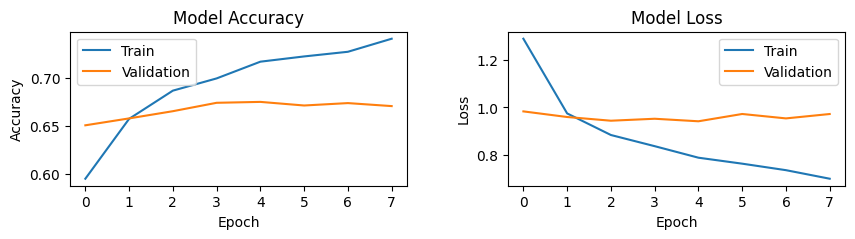

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10,2))

# Plot the accuracy
axes[0].plot(vgg.history['accuracy'])
axes[0].plot(vgg.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the loss
axes[1].plot(vgg.history['loss'])
axes[1].plot(vgg.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


### **Imagenet**

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained InceptionResNetV2 model
inception_resnet_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_resnet_base.trainable = False

# Add custom classification layers on top
x = inception_resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

# Create the model
inception_resnet_model = Model(inputs=inception_resnet_base.input, outputs=predictions)

# Compile the model
inception_resnet_model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
inception_resnet_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_218 (Conv2D)            (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_207 (Batch  (None, 111, 111, 32  96         ['conv2d_218[0][0]']             
 Normalization)                 )                                                           

In [ ]:
# Train the model
history_inception=inception_resnet_model.fit(less_train_ds, validation_data=less_val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
400/400 [==============================] - 113s 243ms/step - loss: 0.7024 - accuracy: 0.7578 - val_loss: 0.6148 - val_accuracy: 0.7903
Epoch 2/10
400/400 [==============================] - 90s 225ms/step - loss: 0.5695 - accuracy: 0.7934 - val_loss: 0.5915 - val_accuracy: 0.7972
Epoch 3/10
400/400 [==============================] - 91s 227ms/step - loss: 0.5195 - accuracy: 0.8103 - val_loss: 0.6150 - val_accuracy: 0.7931
Epoch 4/10
400/400 [==============================] - 90s 224ms/step - loss: 0.4808 - accuracy: 0.8213 - val_loss: 0.6060 - val_accuracy: 0.7978
Epoch 5/10
400/400 [==============================] - 91s 227ms/step - loss: 0.4374 - accuracy: 0.8363 - val_loss: 0.6609 - val_accuracy: 0.7884


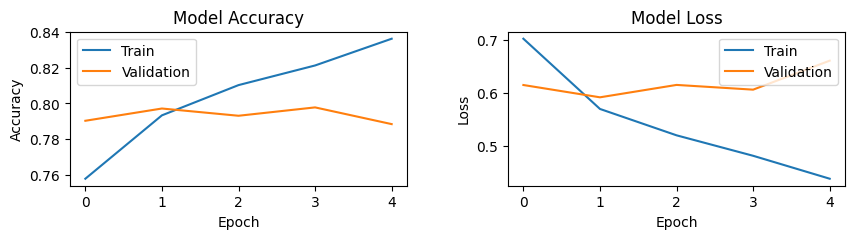

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10,2))

# Plot the accuracy
axes[0].plot(history_inception.history['accuracy'])
axes[0].plot(history_inception.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the loss
axes[1].plot(history_inception.history['loss'])
axes[1].plot(history_inception.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


#### **Unfreezing a few layers to see, how it changes accuracy**

In [ ]:
from tensorflow.keras.applications import VGG16

# Check the total number of layers

total_layers = len(inception_resnet_model.layers)
print("Total number of layers:", total_layers)

# Check the trainable number of layers

trainable_layers = sum([1 for layer in inception_resnet_model.layers if layer.trainable])
print("Number of trainable layers:", trainable_layers)


Total number of layers: 784
Number of trainable layers: 4


In [ ]:
# Specify the number of layers to unfreeze
num_layers_to_unfreeze = 200
layers_unfrozen = 0

for layer in inception_resnet_model.layers:
    layer.trainable = True
    layers_unfrozen += 1
    
    if layers_unfrozen == num_layers_to_unfreeze:
        break

# Check the trainable status of each layer after freezing
trainable_layers = sum([1 for layer in inception_resnet_model.layers if layer.trainable])
print("Number of trainable layers:", trainable_layers)

Number of trainable layers: 204


In [ ]:
# Train the model
history_inception_2=inception_resnet_model.fit(less_train_ds, validation_data=less_val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
400/400 [==============================] - 89s 223ms/step - loss: 0.4023 - accuracy: 0.8484 - val_loss: 0.7184 - val_accuracy: 0.7700
Epoch 2/10
400/400 [==============================] - 88s 220ms/step - loss: 0.3761 - accuracy: 0.8574 - val_loss: 0.6797 - val_accuracy: 0.7759
Epoch 3/10
400/400 [==============================] - 89s 221ms/step - loss: 0.3538 - accuracy: 0.8633 - val_loss: 0.7181 - val_accuracy: 0.7775
Epoch 4/10
400/400 [==============================] - 89s 221ms/step - loss: 0.3319 - accuracy: 0.8775 - val_loss: 0.7235 - val_accuracy: 0.7722
Epoch 5/10
400/400 [==============================] - 93s 233ms/step - loss: 0.3070 - accuracy: 0.8820 - val_loss: 0.7891 - val_accuracy: 0.7547


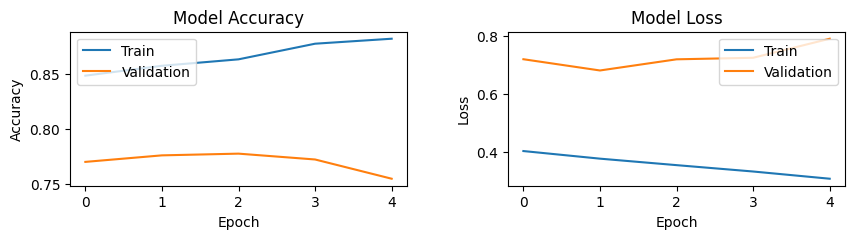

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10,2))

# Plot the accuracy
axes[0].plot(history_inception_2.history['accuracy'])
axes[0].plot(history_inception_2.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the loss
axes[1].plot(history_inception_2.history['loss'])
axes[1].plot(history_inception_2.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16

# Check the total number of layers

total_layers = len(inception_resnet_model.layers)
print("Total number of layers:", total_layers)

# Check the trainable number of layers

trainable_layers = sum([1 for layer in inception_resnet_model.layers if layer.trainable])
print("Number of trainable layers:", trainable_layers)


Total number of layers: 784
Number of trainable layers: 204


In [ ]:
# Specify the number of layers to unfreeze in Imagenet
num_layers_to_unfreeze = 400
layers_unfrozen = 0

for layer in inception_resnet_model.layers:
    layer.trainable = True
    layers_unfrozen += 1
    
    if layers_unfrozen == num_layers_to_unfreeze:
        break

# Check the trainable status of each layer after freezing
trainable_layers = sum([1 for layer in inception_resnet_model.layers if layer.trainable])
print("Number of trainable layers:", trainable_layers)

Number of trainable layers: 404


In [ ]:
# Train the model
history_inception_3=inception_resnet_model.fit(less_train_ds, validation_data=less_val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
400/400 [==============================] - 90s 224ms/step - loss: 0.2781 - accuracy: 0.8942 - val_loss: 0.7830 - val_accuracy: 0.7859
Epoch 2/10
400/400 [==============================] - 90s 224ms/step - loss: 0.2530 - accuracy: 0.9030 - val_loss: 0.8561 - val_accuracy: 0.7725
Epoch 3/10
400/400 [==============================] - 89s 223ms/step - loss: 0.2416 - accuracy: 0.9080 - val_loss: 0.9168 - val_accuracy: 0.7825
Epoch 4/10
400/400 [==============================] - 90s 224ms/step - loss: 0.2330 - accuracy: 0.9097 - val_loss: 1.0347 - val_accuracy: 0.7791


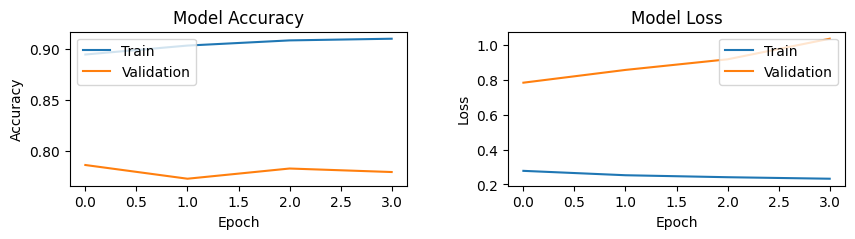

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10,2))

# Plot the accuracy
axes[0].plot(history_inception_3.history['accuracy'])
axes[0].plot(history_inception_3.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot the loss
axes[1].plot(history_inception_3.history['loss'])
axes[1].plot(history_inception_3.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plots
plt.show()


Trying to train layers, by unfreezing them, didn't increase the accuracy much, but we tried with a very small dataset. We can try with a larger dataset to see how that affects our Fine Tuning through un-freezing layers.

### **EfficientNet**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_shape = (224, 224, 3)
EfficientNet = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2", input_shape=input_shape)
])

In [ ]:
EfficientNet_model = tf.keras.Sequential([
    EfficientNet,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='softmax')
])


In [ ]:

EfficientNet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
EfficientNet_model.fit(less_train_ds, validation_data=less_val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
400/400 [==============================] - 42s 105ms/step - loss: 0.1251 - accuracy: 0.9520 - val_loss: 0.8195 - val_accuracy: 0.8475
Epoch 2/10
400/400 [==============================] - 47s 116ms/step - loss: 0.1169 - accuracy: 0.9568 - val_loss: 0.8636 - val_accuracy: 0.8425
Epoch 3/10
400/400 [==============================] - 51s 126ms/step - loss: 0.1080 - accuracy: 0.9600 - val_loss: 0.8867 - val_accuracy: 0.8378
Epoch 4/10
400/400 [==============================] - 46s 114ms/step - loss: 0.0974 - accuracy: 0.9634 - val_loss: 0.9607 - val_accuracy: 0.8441


For this model, we can try fine tuning and also working with larger sets of data to further improve the accuracy. We can't comment for sure that it will improve or decrease the overall performance of the model, but we cant try.

In [ ]:
# Make predictions on the test dataset
y_pred = EfficientNet_model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1) # Convert probabilities to class labels

# Get the true labels of the test dataset
y_true = np.concatenate([y.numpy() for _, y in val_ds])

# Generate the classification report
report = classification_report(y_true, y_pred)
print(report)

1563/1563 [==============================] - 139s 89ms/step
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      9935
           1       0.88      0.75      0.81      1049
           2       0.77      0.61      0.68       993
           3       0.79      0.69      0.74       928
           4       0.82      0.89      0.86     17969
           5       0.93      0.88      0.91     13006
           6       0.65      0.59      0.62      5075
           7       0.87      0.50      0.64      1045

    accuracy                           0.85     50000
   macro avg       0.83      0.73      0.77     50000
weighted avg       0.85      0.85      0.85     50000



**Comments on Metrics**

Precision: The precision metric measures the proportion of correctly predicted instances for each class. Higher precision values indicate a lower rate of false positives. The precision values range from 0.65 to 0.93.

Recall: The recall metric measures the proportion of true positive instances correctly identified for each class. Higher recall values indicate a lower rate of false negatives. The recall values range from 0.50 to 0.94.

F1-score: The F1-score is the mean of precision and recall, providing a balanced measure of the model's performance for each class. The F1-scores range from 0.62 to 0.92.


In summary, the model achieves relatively high precision, recall, and F1-score for most classes, with some variation across different categories. The overall accuracy is 85%, indicating reasonably good performance.

**Comments on Loss and accuracy**

Loss: The model's loss values decreased with each epoch, indicating that it improved in terms of minimizing the discrepancy between predicted and actual values on the training data.

Accuracy: The training accuracy increased gradually from 0.9520 to 0.9634 over the epochs, suggesting that the model learned to make more accurate predictions on the training data.

Validation Loss: The validation loss started at 0.8195 and slightly increased over the epochs, reaching 0.9607 in the last epoch. This could suggest a decline in the model's performance on unseen validation data after the initial improvements.

Validation Accuracy: The validation accuracy fluctuated between 0.8378 and 0.8441, indicating relatively stable performance on the validation set without significant improvement.

In [ ]:
predictions_efficientnet=EfficientNet_model.predict(val_ds)

1563/1563 [==============================] - 170s 86ms/step


## **Private Test**

In [ ]:
# Your file will probably be called this, if you used the regular Kaggle download. 
!unzip -q /gdrive/MyDrive/COMP8220_MajorProject/living-thing-classification-coarse-private.zip     # CHANGE DIRECTORY

In [ ]:
batch_size = 32
img_size = 224
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('/content/privtest_coarse')

In [ ]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=224):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=224):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / 'privtest'/ fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset




In [ ]:
private_test_ds=create_dataset_tf('privtest_coarse', fine_grained=fine_grain, batch_size=batch_size, image_size=224)

In [ ]:
import pandas as pd

def generate_predictions(model, test_ds, root, pred_file):
    y_pred = []
    for images, _ in private_test_ds:
        predictions = tf.argmax(model.predict(images), axis=1).numpy()
        y_pred.extend(predictions)

    # Create a DataFrame with the predicted labels
    test_csv = pd.read_csv(root / "privtest_coarse.csv")  # Replace "root" with the appropriate directory
    test_csv["coarse"] = y_pred

    # Save the predictions to a CSV file
    test_csv.to_csv(pred_file, index=False)


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pretrained and saved model and specify the custom objects
model_coarse_private_1 = load_model('/gdrive/MyDrive/COMP8220_MajorProject/tfhub_28_coarse_final.h5', custom_objects={'KerasLayer': hub.KerasLayer})
model_fine_private_1 = load_model('/gdrive/MyDrive/COMP8220_MajorProject/tfhub_28_fine_03.h5', custom_objects={'KerasLayer': hub.KerasLayer})


In [ ]:
generate_predictions(model, private_test_ds, root, "/gdrive/MyDrive/COMP8220_MajorProject/46238050-deep-C01.csv")

# **FINE DATASET**

For fine Dataset we use the models we obtained as best on Coarse Dataset i.e EfficientNet and we implement the same on fine.

In [ ]:
batch_size = 32
img_size = 224
fine_grain = True 
num_classes = 50 if fine_grain else 8
root = Path('/content/public')

In [ ]:
X,Y = create_dataset_sklearn('train', fine_grained=False)

In [ ]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=batch_size)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=batch_size)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=batch_size)

### **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=500, random_state=1)
rfc.fit(X_train, Y_train)


RandomForestClassifier(n_estimators=500, random_state=1)

In [ ]:
y_pred=rfc.predict(X_val)
accuracy= accuracy_score(Y_val, y_pred)
print(accuracy)

0.458


**Hyperparameter Tuning for Random Forest Classifier**

Tuning Random Forest Classifier for obtaining the best Hyperparameters of n_estimator and max_depth, to see if it improves the accuracy any further and substantially.

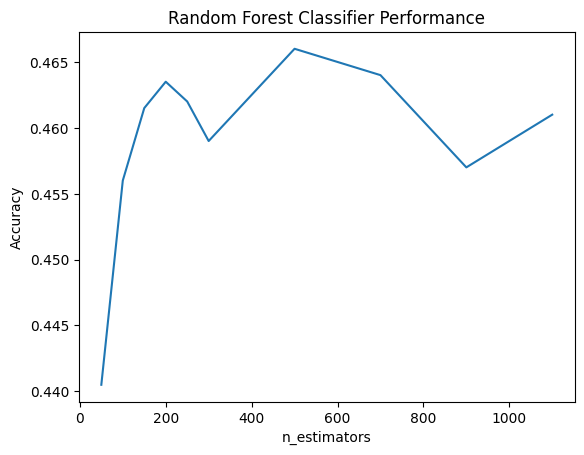

In [ ]:
## finding optimum value of n_estimator by trying different values
scores=[]
n_list = [50, 100, 150, 200, 250, 300,500, 700, 900, 1100]

for n_estimators in n_list:
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rfc.fit(X_train, Y_train)
    score = rfc.score(X_val, Y_val)
    scores.append(score)

# Plot the scores vs. n_estimators
plt.plot(n_list, scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Performance')
plt.show()

In [ ]:
optimum_n_estimators = n_list[scores.index(max(scores))]
print('Optimum value of n_estimators:', optimum_n_estimators)

Optimum value of n_estimators: 500


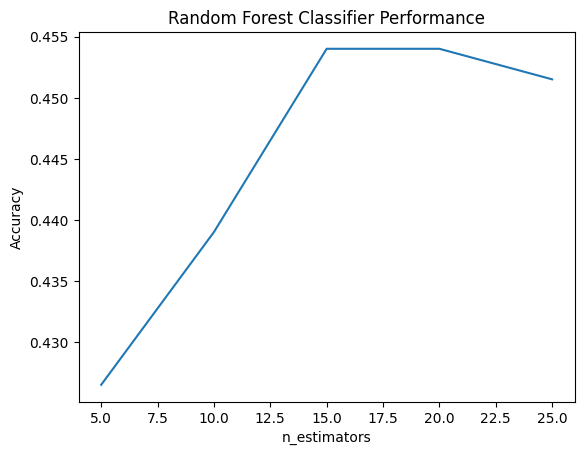

In [ ]:
## finding optimum value of max_depth
scores=[]
max_depth_list = [5,10,15,20,25]

for max_depth in max_depth_list:
    rfc = RandomForestClassifier(max_depth=max_depth, random_state=42)
    rfc.fit(X_train, Y_train)
    score = rfc.score(X_val, Y_val)
    scores.append(score)

# Plot the scores vs. n_estimators
plt.plot(max_depth_list, scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Performance')
plt.show()

In [ ]:
optimum_max_depth = max_depth_list[scores.index(max(scores))]
print('Optimum value of n_estimators:', optimum_max_depth)

Optimum value of n_estimators: 15


We obtained the optimum values for max_depth and n_estimators as 15 and 500, we will re-train our model to see what effect it makes on our accuracy.

In [ ]:
rfc=RandomForestClassifier(n_estimators=500,max_depth=15, random_state=1)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=15, n_estimators=500, random_state=1)

In [ ]:
y_pred=rfc.predict(X_val)

In [ ]:
accuracy= accuracy_score(Y_val, y_pred)
print(accuracy)

0.4535


After Hyperparameter tuning the accuracy doesn't show much improvement and it remains almost stagnant around 0.4535

### **Saving final predictions on Final Conventional Model to File**

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/COMP8220_MajorProject/46238050-conv-001.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file, index=False)

## **Deep Learning**

### **Less Data for training and testing Models**

In [ ]:
less_train_ds=train_ds.take(400)
less_val_ds=val_ds.take(100)

### **EfficientNet**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_shape = (224, 224, 3)
EfficientNet = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2", input_shape=input_shape)
])

In [ ]:
EfficientNet_model = tf.keras.Sequential([
    EfficientNet,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='softmax')
])


In [ ]:

EfficientNet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
EfficientNet_model.fit(less_train_ds, validation_data=less_val_ds, epochs=10)

The mode gives an accuracy score :0.56496, which is decent but more complex model or a bigger pre-trained model can be used to further improve the accuracy of model on Fine dataset.